##1. Imports and Helper Functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import random
import time
from PIL import Image

In [2]:
def bres_segment_count(x0, y0, x1, y1):
  point_list = []
  
  dx = abs(x1 - x0)
  dy = abs(y1 - y0)
  
  sx = 2*int(x0 < x1) - 1
  sy = 2*int(y0 < y1) - 1
  
  err = dx - dy

  x_iter = x0
  y_iter = y0

  while True:
    if x_iter == x1 and y_iter == y1:
      break
    
    point_list.append((x_iter, y_iter))

    e2 = 2 * err
    if e2 > -dy:
      err -= dy
      x_iter += sx

    if e2 < dx:
      err += dx
      y_iter += sy

  return point_list

def draw_polygon(vertex_list):
  full_poly_list = []
  for i, vert in enumerate(vertex_list):
    p1 = vert
    if i >= len(vertex_list) - 1: 
      p2 = vertex_list[0]
    else:
      p2 = vertex_list[i + 1]
    
    line = bres_segment_count(p1[0], p1[1], p2[0], p2[1])

    for val in line:
      full_poly_list.append(val)
  return full_poly_list

def generate_poly_slice_dict(polygon_pixels):
  output_dict = {}
  for value in polygon_pixels:
    x_coord = value[0]
    y_coord = value[1]
    if x_coord not in output_dict.keys():
      output_dict[x_coord] = []
    output_dict[x_coord].append(y_coord)
  return output_dict


##2. Visualization Test

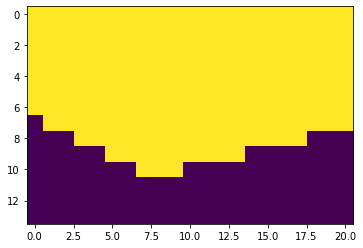

In [3]:
sample_polygon = [(0, 0), (20, 0), (20, 8), (7, 11), (0, 7)]
full_poly_list = draw_polygon(vertex_list=sample_polygon)

# SLICER METHOD - SHOULD WORK OKAY
poly_dict = generate_poly_slice_dict(full_poly_list)
graph = np.zeros([14,21])

for x_val in poly_dict.keys():
  min = np.min(poly_dict[x_val])
  max = np.max(poly_dict[x_val])
  graph[min:max, x_val] = 1

plt.imshow(graph)

In [4]:
# Attempt 1 At Drawing polygon representation of the court

#Step 1: Import Image and JSON Data Associated with that Image
#Step 2: Trim Polygon Points to Match Function Format
#Step 3: Using slicer method, draw out same size image 
#Step 4: Display both to check mapping accuracy

In [5]:
# mounting drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
#Json Data Importing (To get file names)
info_descriptor = open('gdrive/MyDrive/Colab Notebooks/Annotations/100_Samples.json')
info_dict = json.load(info_descriptor)

In [7]:
#JSON Data Parsing
#We want the file_name, id, and points
parsed_dict = {}
for entry in info_dict["images"]:
  parsed_dict[entry["id"]]={}
  parsed_dict[entry["id"]]["file_name"] = entry["file_name"]
  parsed_dict[entry["id"]]["width"] = entry["width"]
  parsed_dict[entry["id"]]["height"] = entry["height"]

for id in parsed_dict.keys():
  vertex_list = []
  for keypoint in info_dict["annotations"]:
    if keypoint["image_id"] == id:
      keypoint_x = keypoint["keypoints"][0]
      keypoint_y = keypoint["keypoints"][1]
      #clip the keypoints

      if keypoint_x > parsed_dict[id]["width"]:
        keypoint_x = parsed_dict[id]["width"] - 1
      elif keypoint_x < 0:
        keypoint_x = 0

      if keypoint_y > parsed_dict[id]["height"]:
        keypoint_y = parsed_dict[id]["height"] - 1
      elif keypoint_y < 0:
        keypoint_y = 0

      vertex_list.append((keypoint_x, keypoint_y))
  parsed_dict[id]["vertices"] = vertex_list

print("'parsed_dict' now has court info: \n{}".format(json.dumps(parsed_dict[list(parsed_dict.keys())[0]], indent=4)))


'parsed_dict' now has court info: 
{
    "file_name": "court_dp_1.jpg",
    "width": 1920,
    "height": 1080,
    "vertices": [
        [
            0,
            661
        ],
        [
            1919,
            610
        ],
        [
            1919,
            1080
        ],
        [
            0,
            1079
        ]
    ]
}


In [1]:
test_id = 1

#Testing drawing of 1920 by 1080
full_poly_list = draw_polygon(vertex_list=parsed_dict[list(parsed_dict.keys())[test_id]]["vertices"])

# SLICER METHOD - SHOULD WORK OKAY
poly_dict = generate_poly_slice_dict(full_poly_list)
graph = np.zeros([parsed_dict[list(parsed_dict.keys())[test_id]]["height"], parsed_dict[list(parsed_dict.keys())[test_id]]["width"]])

for x_val in poly_dict.keys():
  min = np.min(poly_dict[x_val])
  max = np.max(poly_dict[x_val])
  graph[min:max, x_val] = 1

plt.imshow(graph)




NameError: ignored

##3. Data Loading
Will return the data in a format ready to be sent through the model, no additional formatting will be needed


In [9]:
class DataLoader():
  def __init__(self):
    self.image_path = '/content/gdrive/MyDrive/Colab Notebooks/Full_Court_Photo_Set/'
    self.data_dict = parsed_dict
    self.train_share = 0.7
    self.valid_share = 0.2
    self.test_share = 0.1
    self.full_data_list = []
    
    for datapoint in self.data_dict:
      entry_info = self.data_dict[datapoint]
      #Image Conversion -> [H, W, C]
      image = Image.open("{}{}".format(self.image_path, entry_info['file_name']))
      data_img = np.asarray(image)
      #print(data_img.shape)

      #Label Conversion -> 
      full_poly_list = draw_polygon(vertex_list=entry_info["vertices"])
      # SLICER METHOD - SHOULD WORK OKAY
      poly_dict = generate_poly_slice_dict(full_poly_list)
      data_label = np.zeros([entry_info["height"], entry_info["width"]])
      for x_val in poly_dict.keys():
        min = np.min(poly_dict[x_val])
        max = np.max(poly_dict[x_val])
        data_label[min:max, x_val] = 1
      #print(data_label.shape)

      '''
      f, axarr = plt.subplots(1,2)
      axarr[0].imshow(data_img)
      axarr[1].imshow(data_label)
      '''
      pairing = (data_img, data_label)
      self.full_data_list.append(pairing)
      
    random.shuffle(self.full_data_list)
    split_index = round(len(self.full_data_list) * (self.valid_share + self.train_share))
    self.training_pool = self.full_data_list[0:split_index]
    self.test_pool = self.full_data_list[split_index:]
    print(len(self.training_pool), len(self.test_pool))

  def batchify(self, dataset, batch_size):
    random.shuffle(dataset)
    label_set = []
    input_set = []
    output_set = []
    for val in dataset:
      input, label = val
      input = cv2.resize(input, (720, 480), interpolation = cv2.INTER_AREA)
      label = cv2.resize(label, (720, 480), interpolation = cv2.INTER_AREA)
      input = np.swapaxes(input, 0, 1)
      input = np.swapaxes(input, 0, 2)
      input_set.append(input)
      label_set.append(label)
      if len(input_set) == batch_size:
        input_set = np.array(input_set)
        label_set = np.array(label_set)
        output_set.append((input_set, label_set))
        input_set = []
        label_set = []
    return output_set

  def training(self, batch_size):
    random.shuffle(self.training_pool)
    split_index = int(((self.train_share)/(self.train_share + self.valid_share))*len(self.training_pool))
    train_set = self.training_pool[0:split_index]
    valid_set = self.training_pool[split_index:]
    train_set = self.batchify(train_set, batch_size)
    valid_set = self.batchify(valid_set, batch_size)
    return train_set, valid_set
  
  def test(self, batch_size):
    test_set = self.batchify(self.test_pool, batch_size)
    return test_set
  
  def full(self):
    return(self.full_data_list)
  
  def all(self, batch_size):
    a, b = self.training(batch_size)
    c = self.test(batch_size)
    return(a, b, c)
  
  def display(self, dataset):
    for element in dataset:
      input, label = element
      f, axarr = plt.subplots(1,2)
      axarr[0].imshow(input)
      axarr[1].imshow(label)


In [10]:
data = DataLoader()
train, val, test = data.all(batch_size=70)

len(train)

KeyboardInterrupt: ignored

In [11]:
print(len(train))

1


##4. Auto Encoder


In [27]:
new_t = torch.tensor([[[0, 0, 0],[0, 0, 1],[1, 1, 0]],[[0, 1, 1],[0, 0, 0],[1, 0, 0]],[[1, 0, 1],[1, 1, 1],[0, 0, 1]]])
acc_all = 0
acc_avg = 0
for i in new_t:
  sum = int(torch.sum(i))
  elem = int(i.numel())
  acc = sum/elem
  acc_all += sum
  print(i)
  print(sum, elem)
  print(acc)
  acc_avg += acc
acc_avg = acc_avg / len(list(new_t))
acc_all = acc_all / new_t.numel()
print(acc_avg, acc_all)

tensor([[0, 0, 0],
        [0, 0, 1],
        [1, 1, 0]])
3 9
0.3333333333333333
tensor([[0, 1, 1],
        [0, 0, 0],
        [1, 0, 0]])
3 9
0.3333333333333333
tensor([[1, 0, 1],
        [1, 1, 1],
        [0, 0, 1]])
6 9
0.6666666666666666
0.4444444444444444 0.4444444444444444


In [10]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride = 2),
            nn.ReLU(),
            nn.Conv2d(256, 512, 3, stride = 2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 3, stride=2),
            nn.ReLU(),
            #nn.ConvTranspose2d(256, 256, 1, stride=1),
            #nn.ReLU(),
            nn.ConvTranspose2d(256, 256, 3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 1, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 1, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 2, stride=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        #print("Encoding Output Shape: {}".format(x.shape))
        x = self.decoder(x)
        #print("Final Output Shape: {}".format(x.shape))
        return x

In [28]:
from matplotlib import figure

def plot_training_curve(train_acc, train_loss, val_acc, val_loss):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.
    """
    import matplotlib.pyplot as plt
    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    
def get_accuracy(model, dataset, batch_size, criterion):
  #NOT PREPPED FOR BATCHES YET
  total_accuracy = 0
  loss_total = 0
  for datapoint in dataset:
    input = datapoint[0]
    label = datapoint[1]

    input = torch.from_numpy(input).float()
    label = torch.from_numpy(label).float()
    start = time.perf_counter()
    output = model(input)
    output = output.squeeze(1)
    loss = criterion(output, label)
    end = time.perf_counter()
    print("Time for Model = {}".format(end-start))
    
    #Accuracy Output
    sig_out = F.sigmoid(output)
    sig_output = (sig_out > 0.5).float()
    loss_total = loss_total + loss

    single_acc = int(torch.sum(sig_output == label)) / int(sig_output.numel())
    total_accuracy = total_accuracy + single_acc
  total_accuracy = total_accuracy / len(dataset)
  loss_total = loss_total / len(dataset)
  return total_accuracy, loss_total



def train_auto_encoder(model, epochs=100, batch_size=1, learning_rate = 1e-4):
  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  
  train_acc = []
  val_acc = []
  train_loss = []
  val_loss = []

  valid_acc = 0
  valid_loss = 0

  for e in range(0, epochs):
    if e != 0:
      del train
      del val
    train, val = data.training(batch_size)
    total_accuracy = 0
    
    for datapoint in train:
      start = time.perf_counter()
      input = datapoint[0]
      label = datapoint[1]

      #JUST FOR BATCH SIZE = 1 CASE | NOT YET BATCHED PROPERLY
      input = torch.from_numpy(input).float()
      label = torch.from_numpy(label).float()

      output = model(input)
      output = output.squeeze(1)

      #Accuracy Output
      sig_out = F.sigmoid(output)
      sig_output = (sig_out > 0.5).float().squeeze()
      
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      
      #Type 1 Accuracy:
      single_acc = int(torch.sum(sig_output == label)) / int(sig_output.numel())
      total_accuracy = total_accuracy + single_acc

      #Type 2 Accuracy
    
    final_acc = total_accuracy / len(train)
    train_loss.append(loss)
    train_acc.append(final_acc)

    #val_acc, val_loss = get_accuracy(model, val, batch_size, criterion)

    end = time.perf_counter()
    
    print("Train Acc: {} | Val Acc: {} | Train Loss: {} | Val Loss: {} | Time: {}".format(final_acc, valid_acc, loss, valid_loss,end-start))
    
    if e % (epochs / 5) == 0:
      #valid_acc, valid_loss = get_accuracy(model, val, batch_size, criterion)
      valid_acc = 0
      valid_loss = 0
      val_acc.append(valid_acc)
      val_loss.append(valid_loss)
      output_img = np.array(sig_output)
      output_img = np.array(output_img[0])

      plt.figure()
      plt.imshow(output_img)
    
  inter = epochs / 5
  torch.save(model.state_dict(), '/content/gdrive/MyDrive/Colab Notebooks/model_weights_100samples.pth')
  

90 10


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Acc: 0.5750565062830687 | Val Acc: 0 | Train Loss: 0.6765332221984863 | Val Loss: 0 | Time: 13.39563202499994
Train Acc: 0.6588327959656084 | Val Acc: 0 | Train Loss: 0.56166672706604 | Val Loss: 0 | Time: 13.436541639000097
Train Acc: 0.7843723958333333 | Val Acc: 0 | Train Loss: 0.35820022225379944 | Val Loss: 0 | Time: 13.523202584000046
Train Acc: 0.8305313740079366 | Val Acc: 0 | Train Loss: 0.31904760003089905 | Val Loss: 0 | Time: 13.30644131300005
Train Acc: 0.8313700810185186 | Val Acc: 0 | Train Loss: 0.39600101113319397 | Val Loss: 0 | Time: 13.369073416999981
Train Acc: 0.8396645998677249 | Val Acc: 0 | Train Loss: 0.42381495237350464 | Val Loss: 0 | Time: 13.34771433800006
Train Acc: 0.853436507936508 | Val Acc: 0 | Train Loss: 0.2692929208278656 | Val Loss: 0 | Time: 13.391339158999472
Train Acc: 0.8445546048280421 | Val Acc: 0 | Train Loss: 0.35214632749557495 | Val Loss: 0 | Time: 13.323757882000791
Train Acc: 0.8493284143518517 | Val Acc: 0 | Train Loss: 0.310766

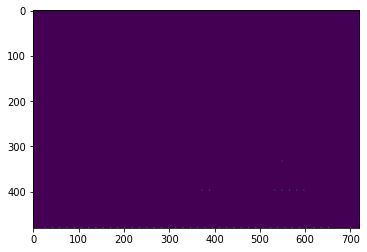

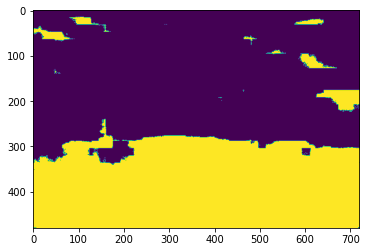

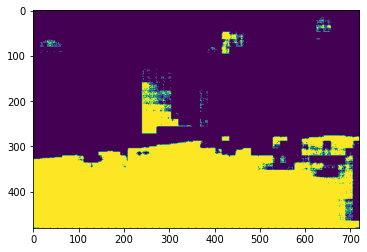

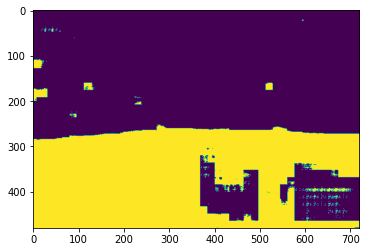

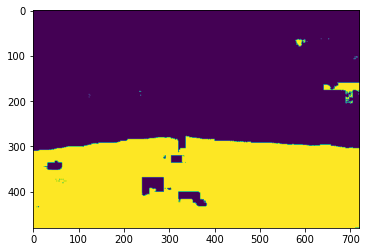

In [29]:
data = DataLoader()
auto = AutoEncoder()
train_auto_encoder(auto, epochs=100, batch_size=5)
#train, val = data.training(1)
#test = data.test(1)
#total_acc = get_accuracy(auto, test, 1)
#print("Total Accuracy = {}".format(total_acc))




In [ ]:
# Showing random sample through the model